# Autoencoder 이용 이상거래 탐지

Keras로 구현된 Autoencoder 신경망을 비지도학습(unsupervised) 또는 반지도학습(semi-supervised) 방식으로 학습하여 신용카드 이상 거래를 탐지해봅니다. 그렇게 학습된 모델은 미리 정답을 알고 있는, 익명화된 데이터셋을 기반으로 평가합니다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### Creditcard fraud 데이터 세트

Creditcard fraud 데이터 세트는 2013년 9월 유럽 카드 소지자가 신용카드로 2일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492건의 비정상 사용 데이터가 있다.  데이터 세트는 매우 불균형하며 positive class(Fruad)는 모든 거래의 0.172%를 차지한다. 

feature 데이터는 기밀 유지 문제로 데이터에 대한 원래 내용과 추가 배경정보는 제공하지 않는다.  컬럼은 V1~ V28로 구성되어, PCA로 한번 가공된 구성요소 이다. PCA 변환 결과 인 숫자 입력 변수만 포함한다. 안타깝게도 기밀 유지 문제로 각 컬럼이 무슨 의미를 하는지는 알 수없다. PCA로 변환되지 않는 유일한 기능은 '시간'과 '양'이다. '시간'에는 각 트랜잭션과 데이터 세트의 첫번째 트랜잭션 사이에 경과 된 시간(초)이 포함된다. '금액',Amount는 거래 금액이며, 이 기능은 예에따라 비용에 민감한 학습에 사용할 수 있다.

'Class' 변수는 부정행위를 하면 1이고, 그렇지 않으면 0을 사용한다.

- 원본 파일은 2 파일
- 파일을 데이터 프레임으로 병합


### 로컬 파일 이용

> 교육을 위해서 github 에 `creditcard_fraud.zip.001` 분할 압축 파일로 제공

## 데이터


구글 데이터세트 검색에서 "creditcard fraud" 를 검색해 신용카드 사기 데이터를 찾는다.

In [ ]:
pd.options.display.max_columns = 50

In [ ]:
df_1 = pd.read_csv('../data/creditcard_1.csv')
df_1.head()

In [ ]:
df_1 = df_1.drop('Unnamed: 0', axis=1)

In [ ]:
df_2 = pd.read_csv('../data/creditcard_2.csv')
df_2 = df_2.drop('Unnamed: 0', axis=1)

### Colab 이용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_1 = pd.read_csv('drive/MyDrive/datasets/creditcard_1.csv')
df_1.head()

In [ ]:
pd.options.display.max_columns = 50

In [ ]:
df_1 = df_1.drop('Unnamed: 0', axis=1)

In [ ]:
df_2 = pd.read_csv('drive/MyDrive/datasets/creditcard_2.csv')
df_2 = df_2.drop('Unnamed: 0', axis=1)

In [ ]:
df_1.shape, df_2.shape

### 두 개의 파일을 하나로 합친다.

- 2개 이상의 DF를 수직 컬럼 방향으로 결합 시키기 위해서 axis=0을 지정

In [ ]:
df_1.shape, df_2.shape

In [ ]:
df = pd.concat([df_1, df_2], axis=0)
df.shape

In [ ]:
del df_1

In [ ]:
del df_2

# 사기와 정상에 대한 값 확인


사기 건에 대한 비율을 확인

In [ ]:
df['Class'].value_counts()

In [ ]:
# 정상-비정상 사용의 비율
Fraud = df[df['Class']==1]
Valid = df[df['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

print(f' {outlier_fraction * 100 :.2f} %')

데이터 세트는 매우 불균형하며 positive class(Fruad)는 모든 거래의 0.172%를 차지한다.

In [ ]:
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

비정상 비율이 꽤 작다 

In [ ]:
sns.countplot(x='Class', data=df)

plt.title("Transaction class distribution")
plt.xticks(range(2), ['Normal','Fraud'])

plt.show()

### 거래 유형별 분석

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(Valid.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


이상 거래가 특정 시간에 더 자주 발생하기도 할까요?

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')

ax2.scatter(Valid.Time, Valid.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

거래가 발생한 시간이 그렇게 중요한 것 같지는 않아 보입니다.

# Autoencoder

'입력값 x를 받아서 다시 입력값 x를 결과로 뱉어내는 함수'가 바로 Autoencoder 신경망이라는 것이죠.

특정한 데이터의 압축된 표상(representation)을 학습시키고 그 구조(structure)를 찾고 싶어한다는 점이 중요합니다. 이것은 모델 안에 있는 은닉 유닛(hidden unit)의 수를 제한하는 방법을 통해 가능합니다. 이런 종류의 autoencoder들은 미완성(undercomplete) 이라 불립니다.

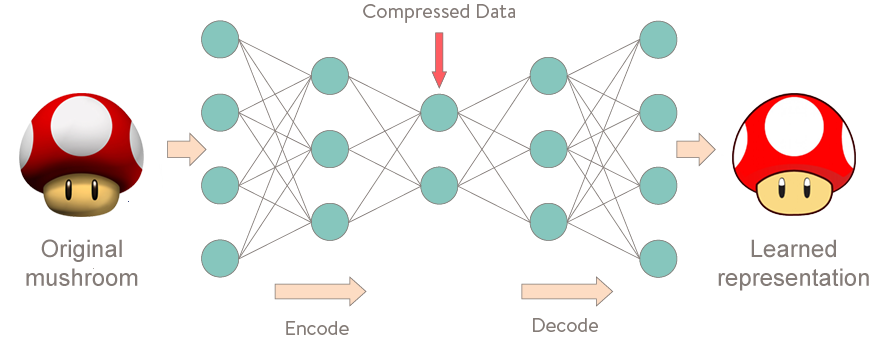

## 훈련 데이터 준비1

먼저, 시간 열은 쓰지 않을 것이기 때문에 삭제하고 Scikit-learn의 StandardScaler를 거래액 열에 적용해봅시다. StandardScaler는 평균을 제거하고 값들을 단위 분산(unit variance)에 맞게 스케일링해줍니다.

딥러닝으로 처리할 때는 모든 칼럼을 정규화나 표준화 필요


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
data = df.drop(['Time'], axis=1)

In [ ]:
data['Amount'].shape

In [ ]:
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

데이터를 훈련과 테스트 세트로 분리

Autoencoder를 훈련하는 것은 우리에게 익숙한 방식과는 조금 다릅니다. 우리가 가진 데이터셋 내에 이상이 없는 거래기록이 대부분이라고 가정해봅시다. 그리고 새로운 거래가 생길 때 어떤 이상이 있으면 그것을 탐지해내고 싶다고 합시다. 그렇다면 우리는 모델을 오직 정상 거래기록으로만 훈련시킵니다. 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가할 수 있습니다. 우리는 가진 데이터의 20%를 테스트에 사용할 것입니다.



In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

### 훈련 데이터 준비2

In [ ]:
# X = df.drop(['Time','Class'], axis=1) #피처 데이터
# y = df['Class']                            #라벨 데이터
# X = df_copy.iloc[:, :-1] #피처 데이터
# y = df_copy.iloc[:, -1] #라벨 데이터

### 모델 만들기

우리가 만들 Autoencoder는 4개의 fully connected layer로 만들어져 있으며, 각 layer는 14, 7, 7, 29개의 뉴런으로 구성되어 있습니다. 처음 두 개의 layer들은 encoder로 쓰이며, 뒤의 두 개는 decoder가 됩니다. 또, L1 정규화(regularization)를 사용합니다.

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

우리가 만든 모델을 100 에폭(epoch) 동안 32의 배치 사이즈(batch size)로 훈련시킨 후, 가장 우수한 성능을 가진 모델을 파일로 저장해봅시다. Keras에서 제공되는 ModelCheckpoint가 이러한 일들을 하는 데 매우 편리합니다. 추가적으로, 훈련 과정은 TensorBoard에 맞는 포맷으로 저장됩니다.b

In [ ]:
from tqdm import tqdm
from tqdm.keras import TqdmCallback

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
// 체크포인트 모델 저장.
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard,TqdmCallback()])

In [ ]:
history

평가

In [ ]:
# Fashion MNIST 분류 모델 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

오류 분포에 대해 좀 더 자세히 살펴봅시다.

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

### 거래의 재구성 오류 분포

정상 거래 데이터들의 재구성 오류 분포

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

이상 거래 데이터들의 재구성 오류 분포

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

### ROC 곡선을 통한 평가

In [ ]:
from sklearn.metrics import ( confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support )

ROC 곡선은 이진 분류기(binary classifier)의 성능을 평가하는 유용한 도구입니다. 그러나 우리의 경우는 살짝 일반적이지는 않습니다. 우리는 굉장히 불균형한 데이터셋을 가지고 있기 때문입니다. 그럼에도, 일단은 우리의 ROC 곡선을 살펴봅시다.

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것입니다. 기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋습니다. 우리의 결과가 꽤 좋아보이긴 하지만, 우리 데이터가 가진 특징을 염두하고 있어야 합니다. ROC 곡선은 여기서 그다지 유용해보이진 않네요.

### 정밀도/재현율

정밀도(Precision)와 재현율(Recall)의 예를 들어보면 정보 검색 분야를 예로 들면, ***정밀도*** 는 검색한 결과들 중에서 실제 찾으려는 대상과 관련된 결과가 얼마나 있는지를 수치화합니다. 반대로, ***재현율*** 은 실제 찾으려는 대상과 관련된 전체 데이터 중 얼마나 찾았는지를 수치화합니다. 두 수치 모두 0과 1사이구요. 수치가 1에 가까울수록 좋습니다.

예시에서 ***재현율이 높지*** 만 <u>정밀도가 낮다는 것은 찾은 데이터의 수가 많지만 그 중 실제 찾으려는 대상의 비율은 낮았다는 것을 의미</u>합니다. 이와 반대로 ***정밀도가 높지*** 만 재현율이 낮다는 것은 찾은 데이터의 수는 작지만 그 중 실제 찾으려는 대상의 비율은 높다는 것을 의미합니다. 이상적으로는 정밀도와 재현율이 모두 높은 것이 좋습니다. 이는 찾은 데이터 수가 많으며 그 중 실제 찾으려는 대상의 비율이 높다는 것을 의미합니다.

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

곡선 아래 영역 중 위쪽 부분은 높은 재현율과 높은 정밀도를 나타냅니다. 높은 정밀도는 거짓인데 참이라고 예측한 것들의 비율이 낮은 것과 관련 있고, 높은 재현율은 참인데 거짓이라고 예측한 것들의 비율이 낮은 것과 관련 있습니다. 두 값 모두 높다면 해당 분류기가 실제 참인 데이터들 중 대부분을 찾아낼(높은 재현율)뿐만 아니라, 정확한 결과(높은 정밀도)를 가진다는 것을 의미합니다.

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

재구성 오류가 증가할수록 정밀도가 올라간다는 것을 확인할 수 있습니다.

재현율도 살펴보자:

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

여기에서는 정반대의 상황이 나타납니다. 재구성 오류가 증가할수록 재현율은 낮아집니다.

## 예측하기

이번에는 우리의 모델이 좀 다릅니다. 우리의 모델은 새로운 값을 어떻게 예측해야 하는지 알지 못합니다. 그러나 우리는 그럴 필요가 없죠. 새로운, 본 적 없는 데이터가 정상 거래인지 이상 거래인지 알기 위해서는 그 데이터에서 나온 재구성 오류를 계산하면 됩니다. 만약 오류가 미리 정해놓은 기준치(threshold)보다 크다면, 우리는 그것을 이상거래로 판단합니다.(정상 거래 데이터에서는 우리의 모델이 작은 오류를 가질 것이기 때문에) 그럼 한 번 기준치를 정해볼까요:

In [ ]:
threshold = 2.9

두 가지 유형의 거래를 얼마나 잘 나누는지 확인해봅시다.

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

차트만으로는 이해하기 힘들 것 같네요. Confusion matrix(분류한 결과를 보여주는 행렬)를 확인해봅시다.

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

우리의 모델이 많은 이상 거래 데이터를 잡아낸 것으로 보입니다. 물론, 문제점도 있긴 합니다. 정상 거래 데이터 중 이상 거래 데이터로 분류된 것들이 꽤 많습니다. 이게 진짜 문제일까요? 그렇겠죠. 아마 독자님의 문제에 따라 기준치를 높이거나 낮추고 싶을 겁니다. 그리고 그렇게 하는 건 독자님의 판단에 달렸습니다.

## 결론

우리는 지금까지 Keras로 정상 거래 기록을 재구성하는 매우 간단한 Deep Autoencoder를 만들어보았습니다.  우리는 수많은 단일 클래스 예시(정상 거래 기록)들만 주었을 뿐인데 모델이 어떻게든 학습해서 새로운 것이 같은 클래스인지 아닌지를 구별할 수 있게 되었습니다. 멋지지 않은가요? 우리의 데이터셋이 마치 마법 같았죠. 우리는 심지어 원래 데이터가 어떻게 생겼는지도 모릅니다.(이미 한 차례 PCA 변환을 거쳤기 때문에)

Keras는 우리에게 자칫 어려울 수도 있는 Deep Autoencoder를 매우 깔끔하고 쉽게 만들 수 있는 API를 제공합니다. Tensorflow 구현체를 찾고 하나를 학습시키기 위해 얼마나 많은 상용코드(boilerplate code, 최소한의 수정만을 거쳐 여러 곳에 필수적으로 사용되는 코드)가 필요한지 직접 확인하는 방법도 있긴 합니다. 자, 그럼 이제 비슷한 모델을 다른 문제에 적용해 볼까요?




## 참조

 - https://blog.keras.io/building-autoencoders-in-keras.html
 - http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
 - http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html

### 저장된 모델 사용하기

In [ ]:
autoencoder = load_model('model.h5')